<a href="https://colab.research.google.com/github/AnalyticsByte/Case-Studies/blob/master/Sales_Forecasting_FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Features** ::



* ***Id:*** transaction ID (combination of Store and date)

* ***Store:*** unique store Id

* ***Sales:*** sales/day, this is the target variable [EUROS]

* ***Customers:*** number of customers on a given day

* ***Open:*** Boolean to say whether a store is open or closed (0 = closed, 1 = open)

* ***Promo:*** describes if store is running a promo on that day or not

* ***StateHoliday:*** indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)

* ***SchoolHoliday:*** indicates if the (Store, Date) was affected by the closure of public schools

* ***StoreType:*** categorical variable to indicate type of store (a, b, c, d)

* ***Assortment:***  a = basic, b = extra, c = extended

* ***CompetitionDistance (meters):*** distance to closest competitor store

* ***CompetitionOpenSince [Month/Year]:***  date when competition was open

* ***Promo2:*** Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)

* ***Promo2Since [Year/Week]*** : date when store started participating in Promo2

* ***PromoInterval:*** describes the consecutive intervals Promo2 is started, naming the months promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that 



##- **Data Source:**
 https://www.kaggle.com/c/rossmann-store-sales/data



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import Sales Training Data**

In [ ]:
sales_train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Sales/train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
sales_train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales_train_df.tail(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017199,1106,2,2013-01-01,0,0,0,0,a,1
1017200,1107,2,2013-01-01,0,0,0,0,a,1
1017201,1108,2,2013-01-01,0,0,0,0,a,1
1017202,1109,2,2013-01-01,0,0,0,0,a,1
1017203,1110,2,2013-01-01,0,0,0,0,a,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
sales_train_df.describe()

# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


### **Import Store information data**

In [ ]:
store_info_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Sales/store.csv')

In [ ]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store_info_df.describe()

# on average, the competition distance is 5404 meters away (5.4 kms)

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


 
## **Data Exploration (Sales)**

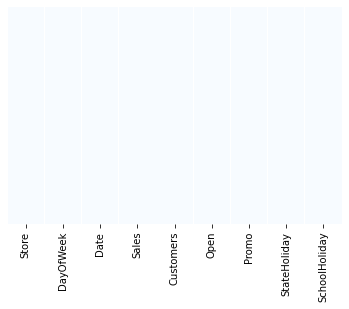

In [ ]:
sns.heatmap(sales_train_df.isnull(),yticklabels=False, cbar=False, cmap='Blues')

# To find any missing values
# no missing values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7ba6c7a90>,
      dtype=object)

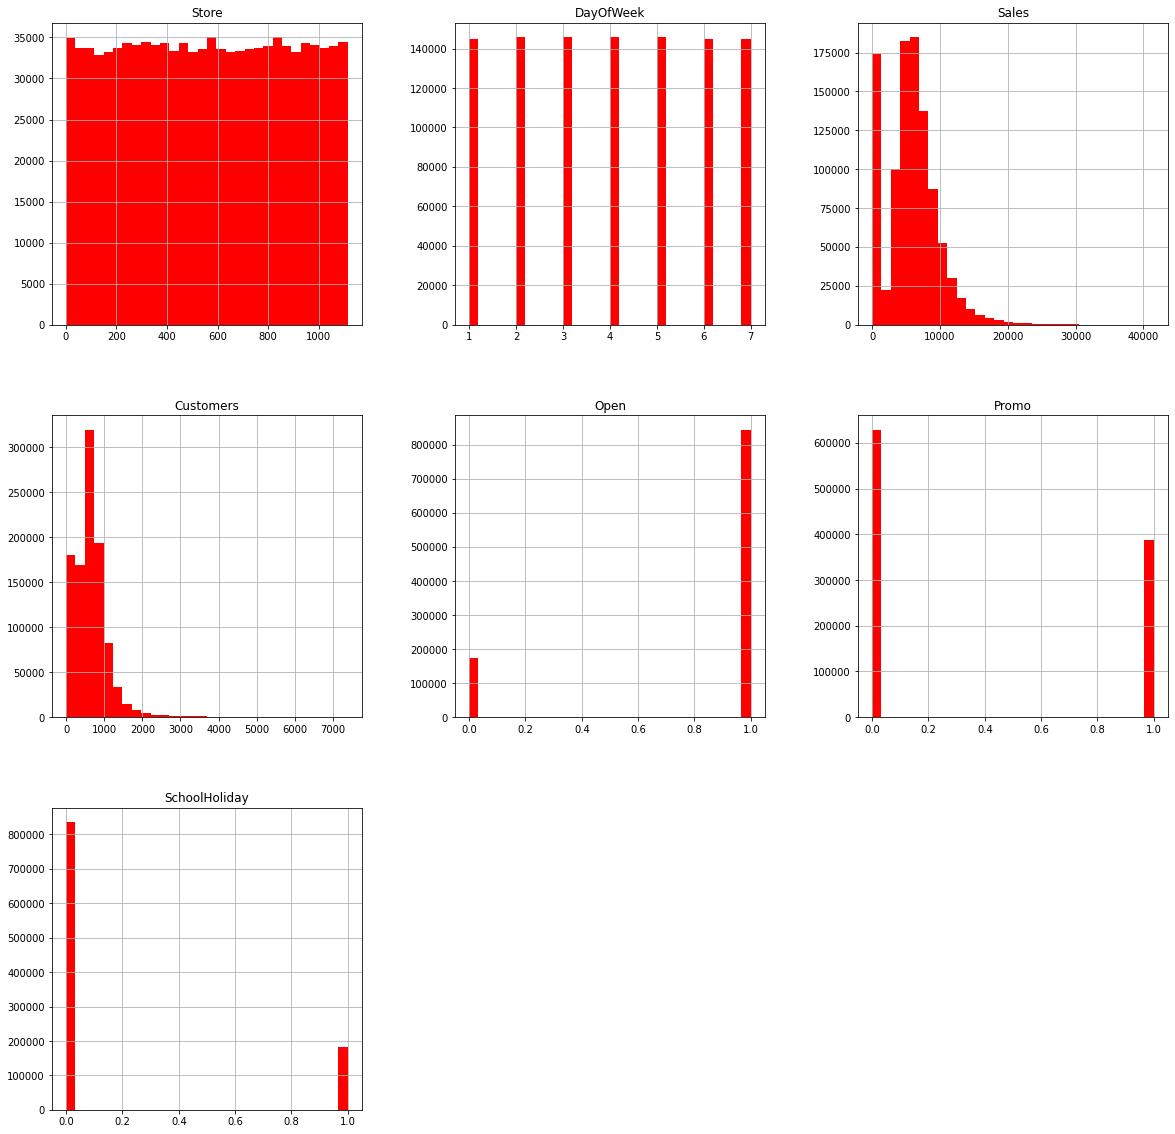

In [ ]:
sales_train_df.hist(bins = 30, figsize= (20,20), color = 'red' )


# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
# Stores are open ~80% of the time
# Data is equally distributed among all stores (no bias)
# Promo #1 was running ~40% of the time 
# Average sales around 5000-6000 Euros
# School holidays are around ~18% of the time

In [ ]:
sales_train_df['Customers'].max()

7388

In [ ]:
# how many stores open and closed
closed_train_df = sales_train_df[sales_train_df['Open']== 0]
open_train_df = sales_train_df[sales_train_df['Open']== 1]

In [ ]:
print('Total = ', len(sales_train_df))
print('Number of closed store = ', len(closed_train_df))
print('Number of open store = ', len(open_train_df))

Total =  1017209
Number of closed store =  172817
Number of open store =  844392


**we are only concern about the open stores (Filtering rows)**


In [ ]:
sales_train_df = sales_train_df[sales_train_df['Open']==1]

In [ ]:
sales_train_df # previously it was approx 10 lakhs entries and now it reduced to approx 8 lakhs entries

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [ ]:
# Drop the Open coloumn, since itt has no meaning now

sales_train_df.drop(['Open'], axis = 1, inplace = True)

In [ ]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [ ]:
# Average sales = 6955 Euros (before 5773), average number of customers = 762 (before 633)
# value went up because we have removed the closed store data

sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


## **Data Exploration (Stores)**

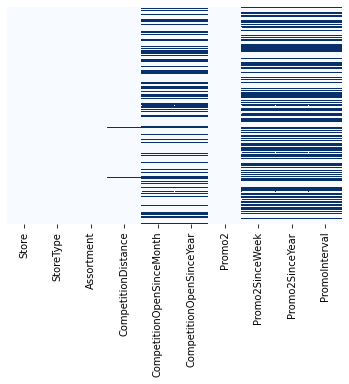

In [ ]:
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar = False, cmap = 'Blues') #checking mising values

In [ ]:
# Let's take a look at the missing values in the 'CompetitionDistance'
# Only 3 rows are missing 

store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# Let's take a look at the missing values in the 'CompetitionOpenSinceMonth'
# many rows are missing = 354 (almost one third of the 1115 stores)

store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
store_info_df[store_info_df['Promo2']== 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
# It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to zero
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing


str_cols = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

In [ ]:
# Let's set the null values to zeroes

for str in str_cols:
  store_info_df[str].fillna(0, inplace = True)

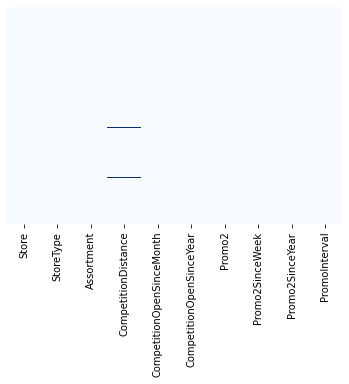

In [ ]:
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar = False, cmap = 'Blues') #checking mising values

In [ ]:
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

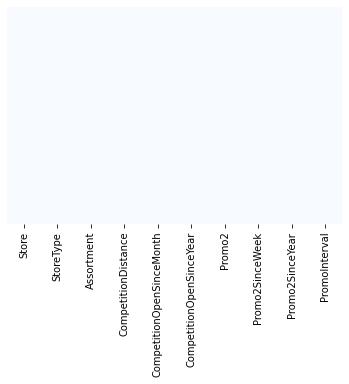

In [ ]:
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar = False, cmap = 'Blues') #checking mising values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b8c99c90>,
      dtype=object)

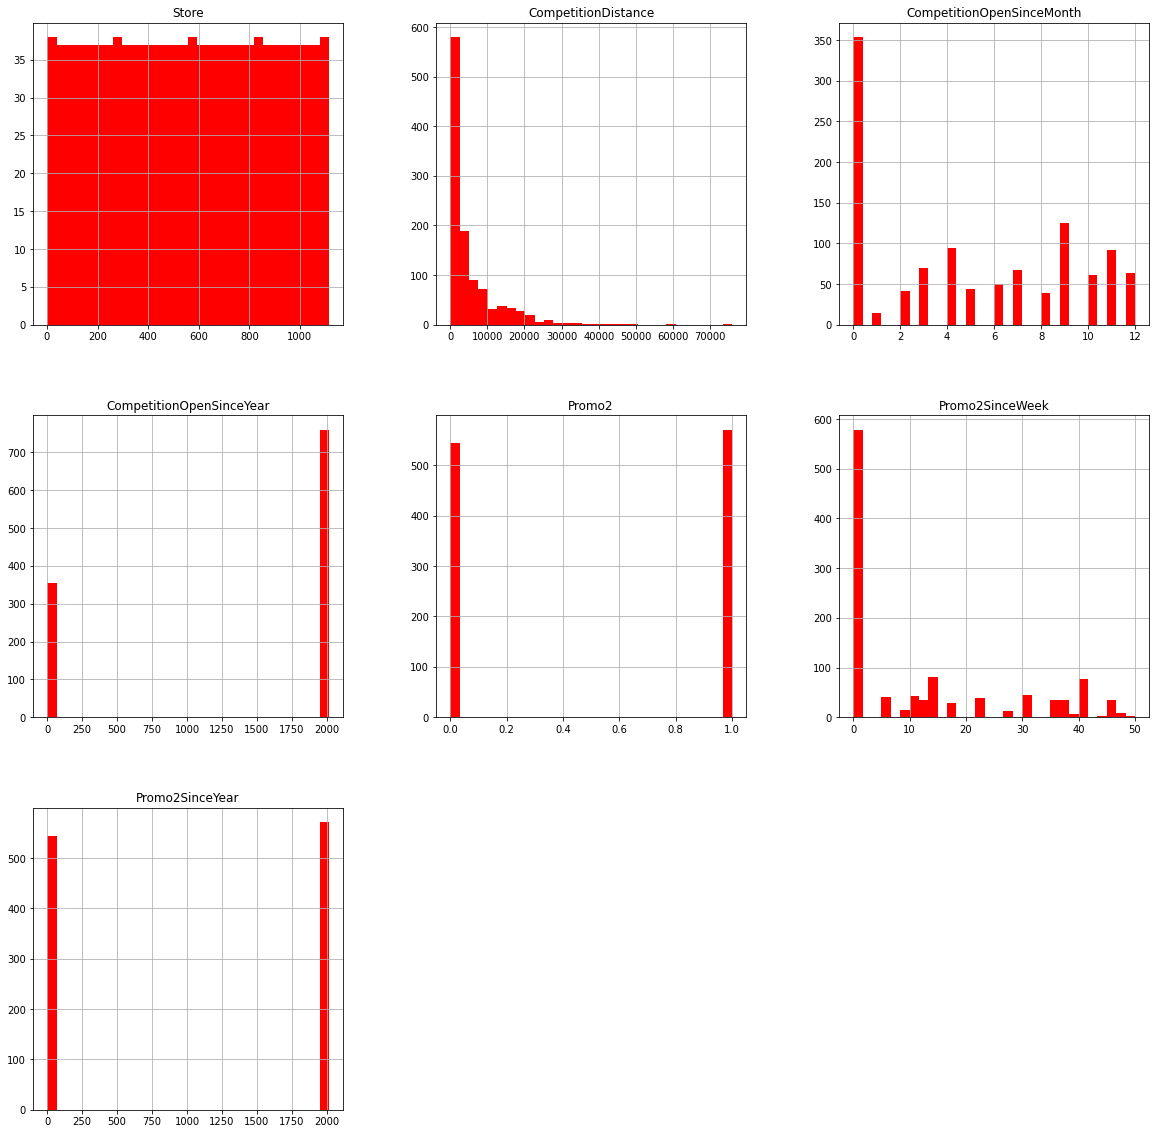

In [ ]:
store_info_df.hist(bins = 30, figsize= (20,20), color = 'Red')

## **Explore Merged Dataset**

In [ ]:
# As both the data set sales and store have common uniques coloumn 'Store' 
# intersection

sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store')

In [ ]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [ ]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations

# customers and promo are positively correlated with the sales 
# Promo2 does not seem to be effective at all 

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

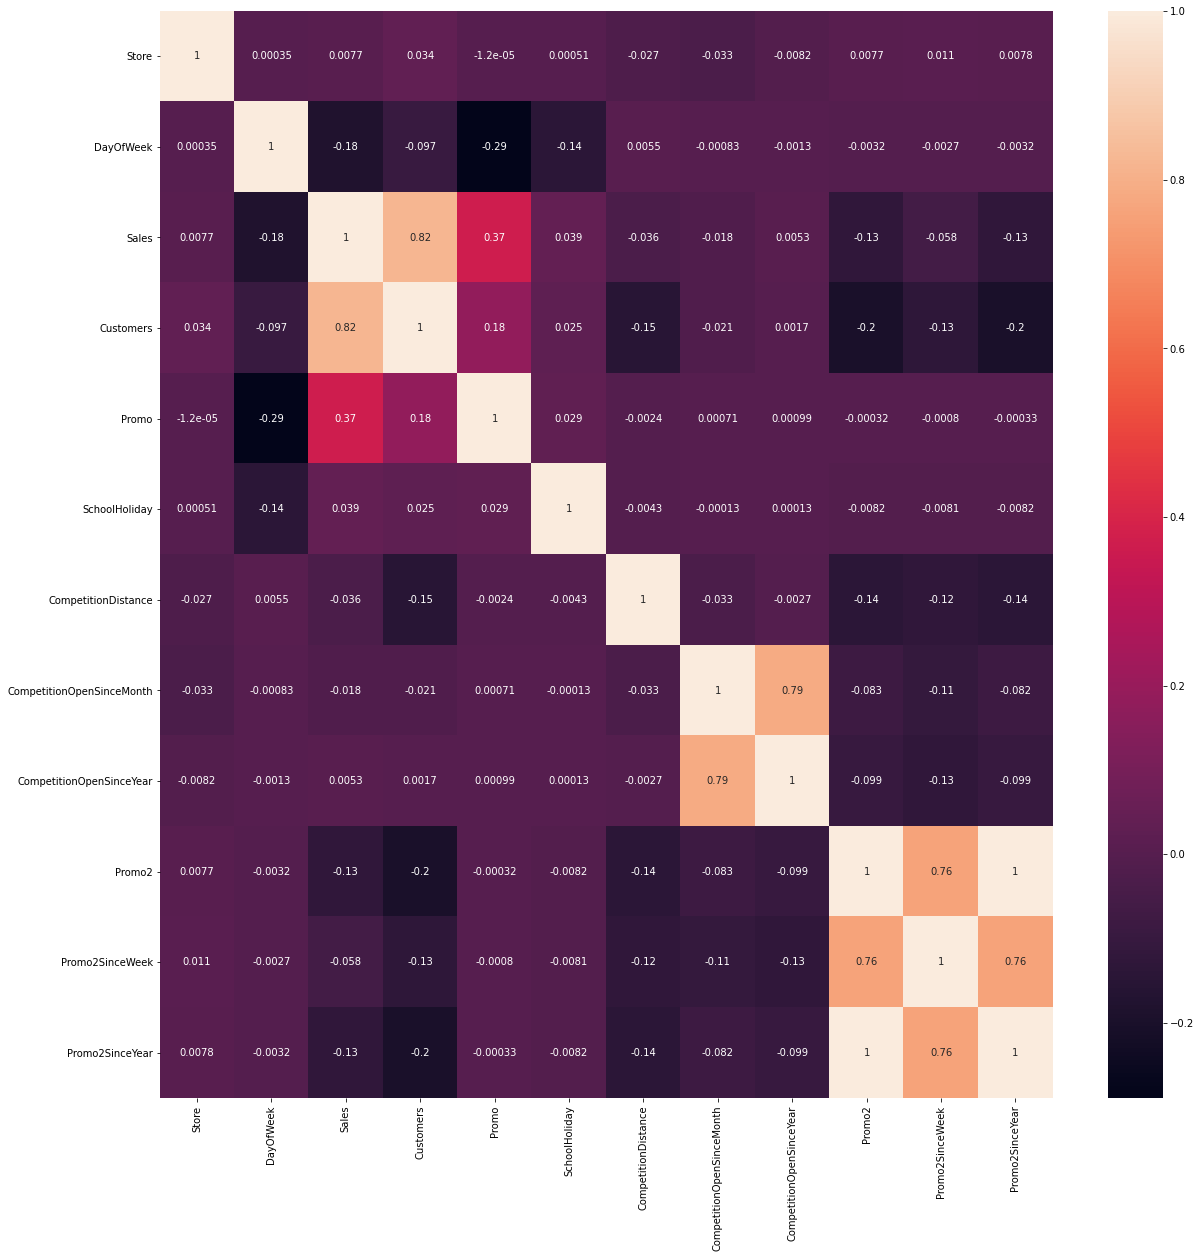

In [ ]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)
# Customers/Prmo and sales are strongly correlated 

In [ ]:
# Let's separate the year, month, day and put it into a separate column 


sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day


In [ ]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


Text(0.5, 1.0, 'Average Customers Per Month')

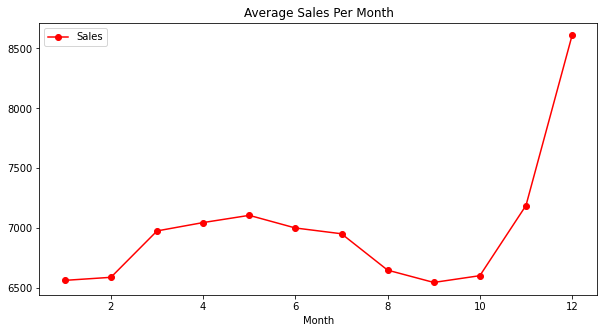

<Figure size 432x288 with 0 Axes>

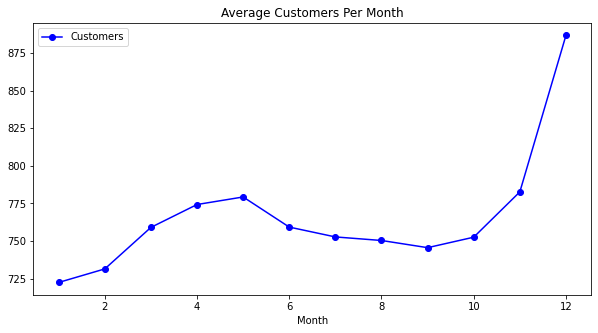

In [ ]:
# Let's take a look at the average sales and number of customers per month 
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column 

axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

plt.figure ()

axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'b')
axis.set_title('Average Customers Per Month')

***It looks like sales and number of customers peak around christmas timeframe***



Text(0.5, 1.0, 'Average Customers Per Day')

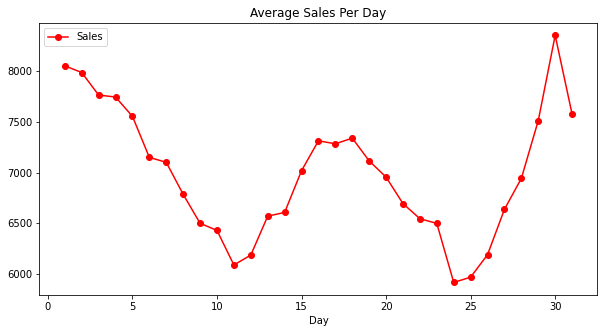

<Figure size 432x288 with 0 Axes>

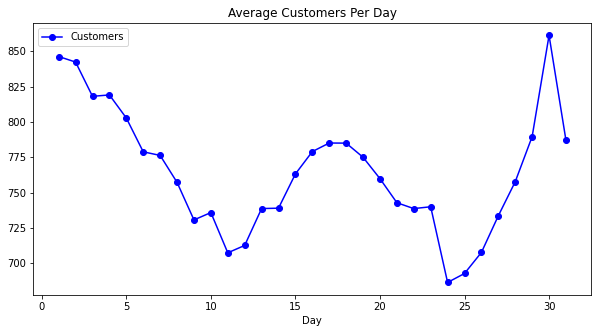

In [ ]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month 


axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

plt.figure ()

axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'b')
axis.set_title('Average Customers Per Day')

***Most customers and sales are around 30th and 1st of the month***

Text(0.5, 1.0, 'Average Customers Per Day of the Week')

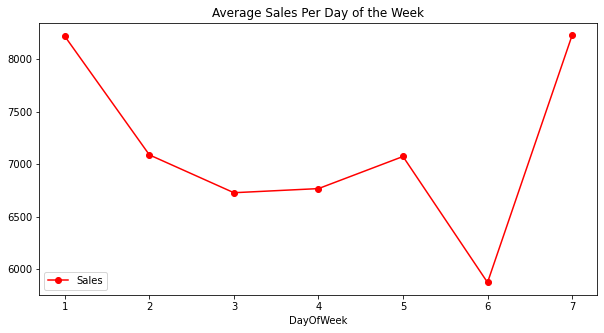

<Figure size 432x288 with 0 Axes>

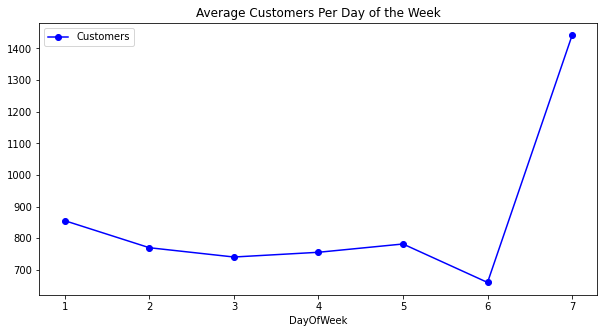

In [ ]:
# Let's do the same for the day of the week  (note that 7 = Sunday)

axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the Week')

plt.figure ()

axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'b')
axis.set_title('Average Customers Per Day of the Week')

***It looks like for 52 weeks in a year the most sales is happening on SUNDAYS***

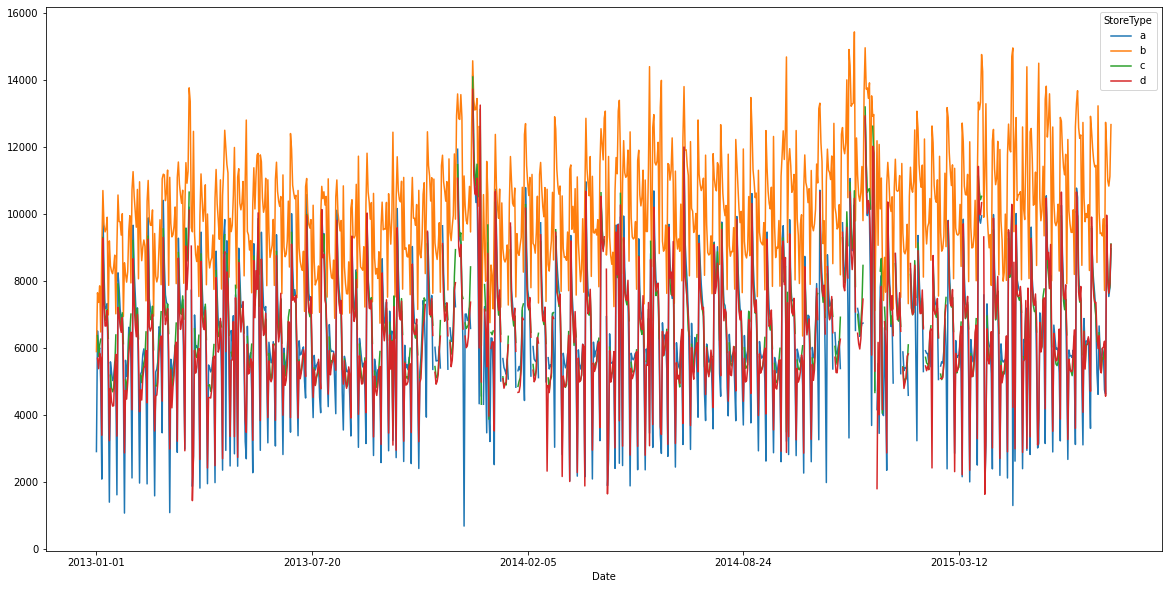

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))

sales_train_all_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

***Store b has the highest values of Sales i.e Orange one***

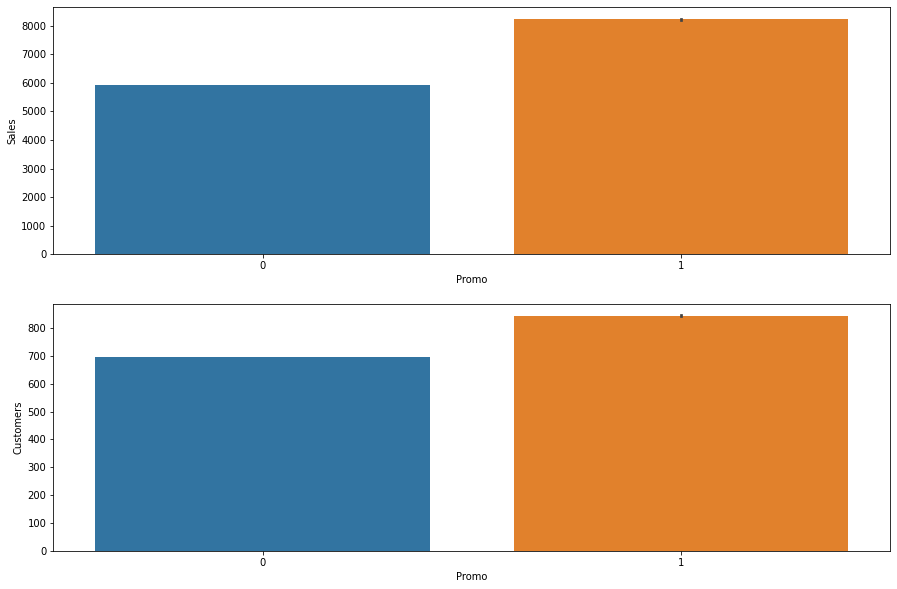

In [ ]:
plt.figure(figsize = [15, 10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)


***After applying Promo the Sales and the Customers have increased***


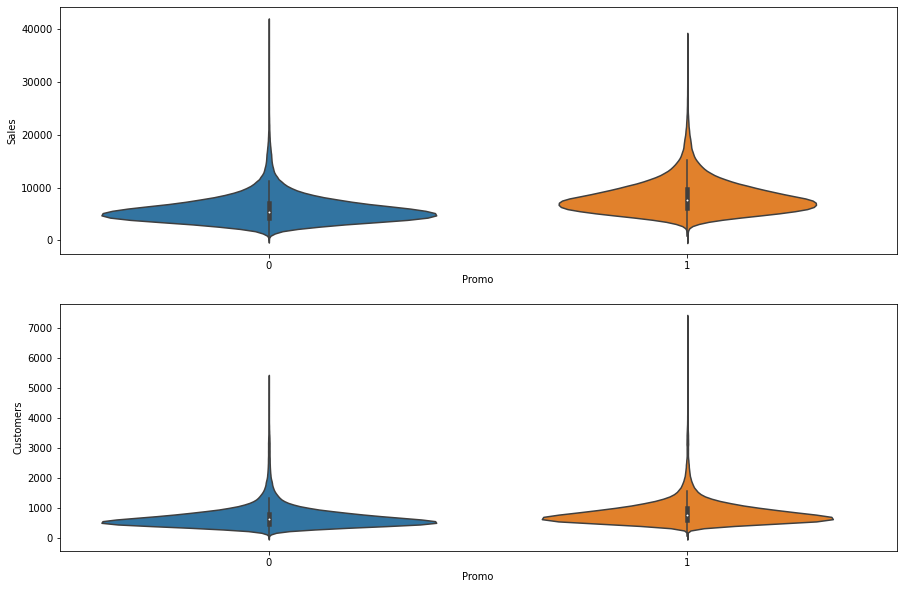

In [ ]:
plt.figure(figsize = [15, 10])

plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)


# **FACEBOOK PROPHET**

* Prophet is open source software releasedby Facebook’s Core Data Science team.

* Prophet is a procedure for forecastingtime series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

* Prophet works best with time series that have strong seasonal effects and several seasons of historical data. 

* No need to perform data preprocessing. It works with missing data and also with outliers


* For more information,please check this out: 

*  https://research.fb.com/prophet-forecasting-at-scale/
*  https://facebook.github.io/prophet/docs/quick_start.html#python-api



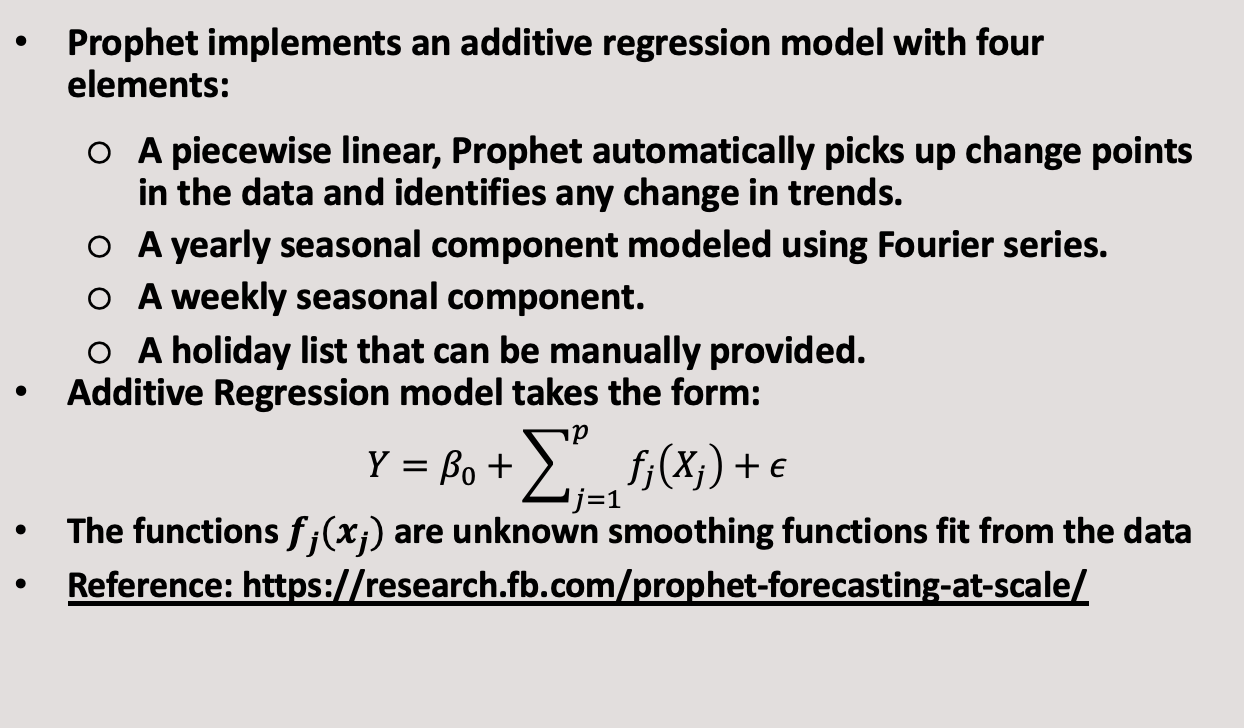

In [ ]:
!pip install fbprophet

In [ ]:
from fbprophet import Prophet

In [ ]:
def sales_predictions(Store_ID, sales_df, periods):

  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df. sort_values('ds') # show from oldest time to the most recent times

  model = Prophet() # Creating objects for Prophet
  model.fit(sales_df) # Fitting the dataframe with the model object

  future = model.make_future_dataframe(periods = periods) # predictions for how many months
  forecast = model.predict(future)

  figure = model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
  figure2 = model.plot_components(forecast)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


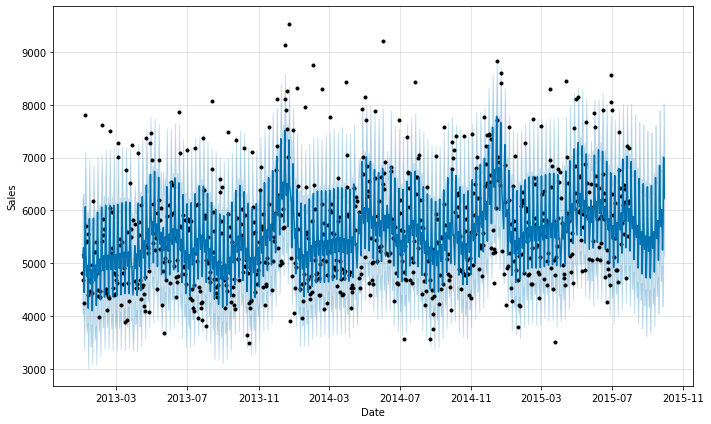

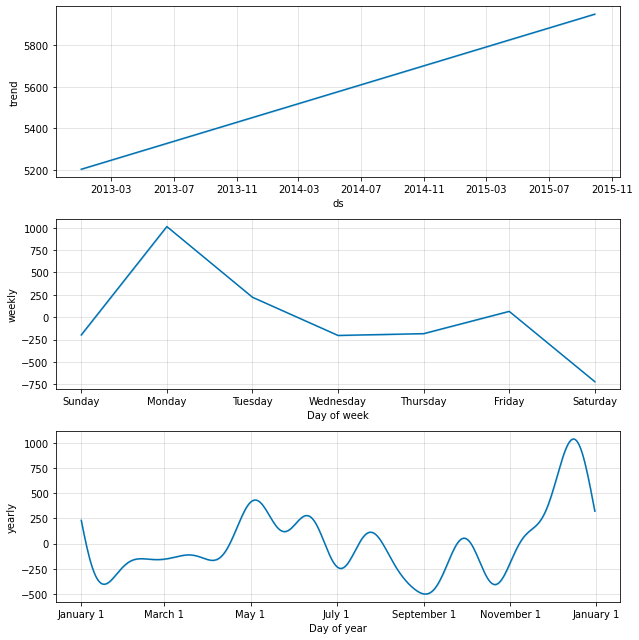

In [ ]:
df = sales_predictions(10, sales_train_all_df, 60)

In [ ]:
def sales_predictions_holidays(Store_ID, sales_df, holidays, periods):

  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df. sort_values('ds') # show from oldest time to the most recent times

  model = Prophet() # Creating objects for Prophet
  model.fit(sales_df) # Fitting the dataframe with the model object

  future = model.make_future_dataframe(periods = periods) # predictions for how many months
  forecast = model.predict(future)

  figure = model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
  figure2 = model.plot_components(forecast)